In [49]:
import math
from operator import itemgetter

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

# Данные

In [3]:
train_data = pd.read_csv('products_sentiment_train.tsv', sep='\t', header=None, names=['text', 'positive'])
train_data.head()

,text,positive
0,"2 . take around 10,000 640x480 pictures .",1
1,i downloaded a trial version of computer assoc...,1
2,the wrt54g plus the hga7t is a perfect solutio...,1
3,i dont especially like how music files are uns...,0
4,i was using the cheapie pail ... and it worked...,1


In [4]:
test_data = pd.read_csv('products_sentiment_test.tsv', sep='\t')
test_data.head()

,Id,text
0,0,"so , why the small digital elph , rather than ..."
1,1,3/4 way through the first disk we played on it...
2,2,better for the zen micro is outlook compatibil...
3,3,6 . play gameboy color games on it with goboy .
4,4,"likewise , i 've heard norton 2004 professiona..."


# Подбор параметров

In [5]:
vectorizer = CountVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression(fit_intercept=False, penalty='l2')

estimator = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier),
])
cross_val_result = cross_val_score(
    estimator,
    train_data.text, train_data.positive, 
    cv=5, scoring='accuracy',
)

np.mean(cross_val_result)

0.7745

# Обучение

In [6]:
estimator.fit(train_data.text, train_data.positive)

Pipeline(steps=[('vectorizer', CountVectorizer(ngram_range=(1, 2))),
                ('classifier', LogisticRegression(fit_intercept=False))])

# Оценка тестовой выборки

In [7]:
test_data['y'] = estimator.predict(test_data.text)
test_data

,Id,text,y
0,0,"so , why the small digital elph , rather than ...",1
1,1,3/4 way through the first disk we played on it...,0
2,2,better for the zen micro is outlook compatibil...,1
3,3,6 . play gameboy color games on it with goboy .,1
4,4,"likewise , i 've heard norton 2004 professiona...",0
...,...,...,...
495,495,i took perfect care of this player and still i...,0
496,496,it 's a very intuitive program .,1
497,497,the only drawback is the viewfinder is slightl...,0
498,498,"it films 10 second video , for crying out loud .",0


In [8]:
test_data.to_csv('my_result.basic.csv', columns=['Id', 'y'], index=False)

# Топ фичей

In [47]:
coefficients = estimator[-1].coef_[0]
words = estimator[0].get_feature_names_out()

features = []
for idx, coef in enumerate(coefficients):
    word = words[idx]
    features.append((idx, math.copysign(1, coef), round(abs(coef), 4), word))

features.sort(key=itemgetter(2), reverse=True)

In [48]:
features[:20]

[(7969, 1.0, 1.9689, 'great'),
 (11079, 1.0, 1.5366, 'love'),
 (13507, -1.0, 1.4606, 'only'),
 (7835, 1.0, 1.2326, 'good'),
 (5891, 1.0, 1.2174, 'easy'),
 (6308, 1.0, 1.135, 'excellent'),
 (22373, -1.0, 1.0085, 'would'),
 (676, -1.0, 1.0038, 'after'),
 (14990, 1.0, 0.9904, 'price'),
 (1653, -1.0, 0.9586, 'annoying'),
 (12679, -1.0, 0.9561, 'norton'),
 (12706, -1.0, 0.9439, 'not'),
 (3418, -1.0, 0.9429, 'buttons'),
 (20602, -1.0, 0.9074, 'unfortunately'),
 (14224, 1.0, 0.9025, 'perfect'),
 (20885, -1.0, 0.8986, 'useless'),
 (2379, 1.0, 0.8717, 'awesome'),
 (8186, 1.0, 0.8676, 'happy'),
 (19466, -1.0, 0.8473, 'they'),
 (4642, 1.0, 0.8456, 'cool')]

# Визуализация данных

In [54]:
vec_data = estimator[0].transform(train_data.text)

In [83]:
imp_vectors = []
for feat_data in features[:20]:
    vec = [x[0] for x in vec_data[:, feat_data[0]].toarray()]
    imp_vectors.append(vec)
imp_vectors = np.array(imp_vectors).transpose()
imp_vectors

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [88]:
vec2 = TSNE(n_components=2, perplexity=20, learning_rate='auto', init='random', random_state=42).fit_transform(imp_vectors)

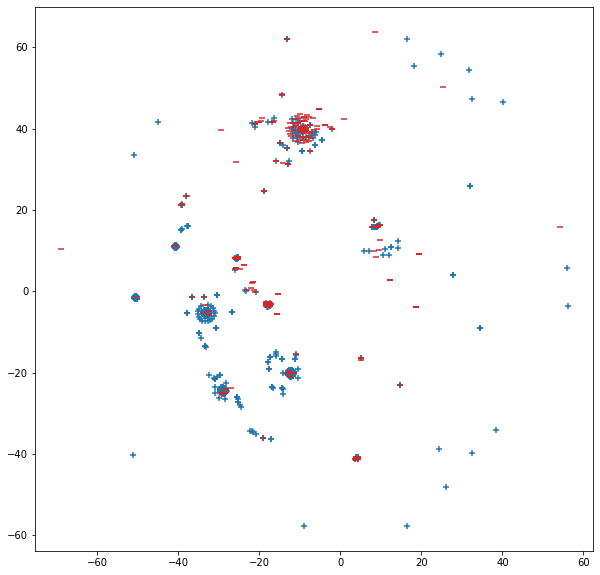

In [89]:
pos_vec2 = vec2[train_data.positive == 1]
neg_vec2 = vec2[train_data.positive == 0]

plt.figure(figsize=(10, 10))

plt.scatter(pos_vec2[:, 0], pos_vec2[:, 1], marker='+', color='tab:blue')
plt.scatter(neg_vec2[:, 0], neg_vec2[:, 1], marker='_', color='tab:red')